In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

2025-10-16 20:15:46.038684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

I0000 00:00:1760638548.206760   78453 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8735 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))


2025-10-16 20:15:48.570382: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-16 20:15:48.635249: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


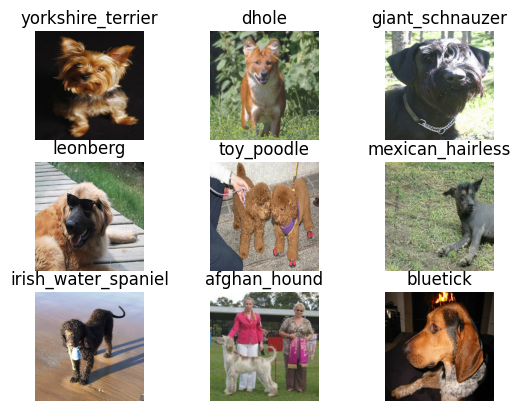

In [4]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [5]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


2025-10-16 20:15:50.339198: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


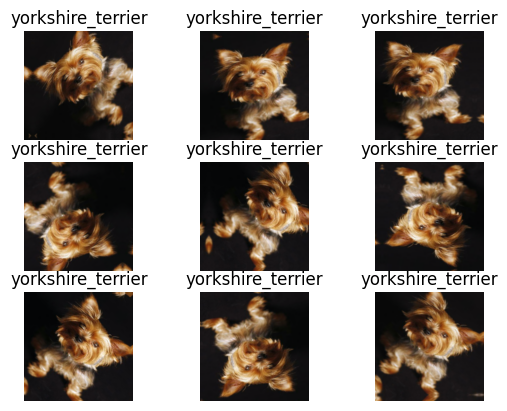

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


In [7]:

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)


In [8]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40


2025-10-16 20:16:05.430221: I external/local_xla/xla/service/service.cc:163] XLA service 0x5cf38ea94140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-16 20:16:05.430239: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-16 20:16:06.032893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-16 20:16:08.761633: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-16 20:16:12.107379: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-16 20:16:12.231348: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed ou

187/187 ━━━━━━━━━━━━━━━━━━━━ 86s 194ms/step - accuracy: 0.0091 - loss: 5.0722 - val_accuracy: 0.0076 - val_loss: 4.8924
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - accuracy: 0.0195 - loss: 4.6873 - val_accuracy: 0.0177 - val_loss: 5.0570
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.0340 - loss: 4.4421 - val_accuracy: 0.0301 - val_loss: 4.7839
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.0414 - loss: 4.3019 - val_accuracy: 0.0421 - val_loss: 4.3967
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.0562 - loss: 4.1912 - val_accuracy: 0.0555 - val_loss: 4.2835
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.0710 - loss: 4.0946 - val_accuracy: 0.0482 - val_loss: 4.4048
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.0753 - loss: 4.0012 - val_accuracy: 0.0661 - val_loss: 4.1639
Epoch 8/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.0813 - loss: 3.9017 - val

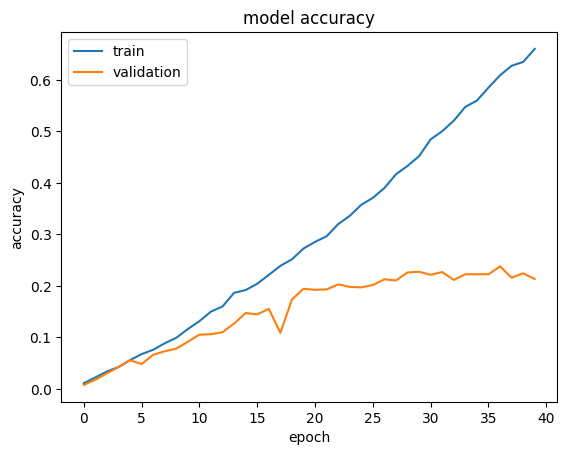

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)


In [10]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model



Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.3401 - loss: 3.8529 - val_accuracy: 0.7371 - val_loss: 0.8633
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.5780 - loss: 1.7334 - val_accuracy: 0.7768 - val_loss: 0.7091
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.6338 - loss: 1.2813 - val_accuracy: 0.7894 - val_loss: 0.6999
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.6500 - loss: 1.2120 - val_accuracy: 0.7923 - val_loss: 0.6965
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.6615 - loss: 1.1608 - val_accuracy: 0.7943 - val_loss: 0.6750
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.6675 - loss: 1.1235 - val_accuracy: 0.7948 - val_loss: 0.6961
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.6695 - loss: 1.1390 - val_accuracy: 0.7865 - val_loss: 0.7156
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.6814 - loss: 1.0959 - 

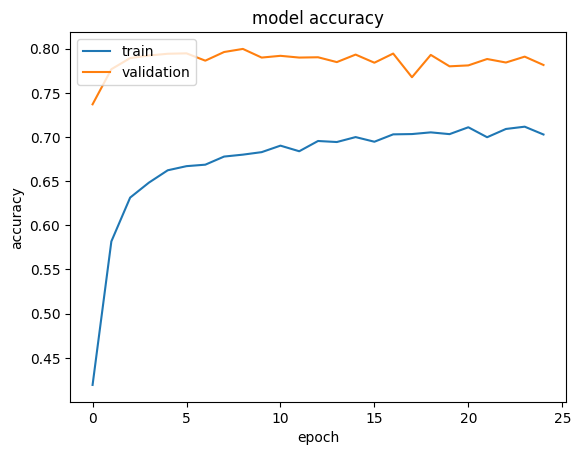

In [11]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)




Epoch 1/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.7274 - loss: 0.9600 - val_accuracy: 0.7952 - val_loss: 0.7617
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7322 - loss: 0.9137 - val_accuracy: 0.8025 - val_loss: 0.7332
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7534 - loss: 0.8734 - val_accuracy: 0.8073 - val_loss: 0.7161
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.7527 - loss: 0.8519 - val_accuracy: 0.8101 - val_loss: 0.7035


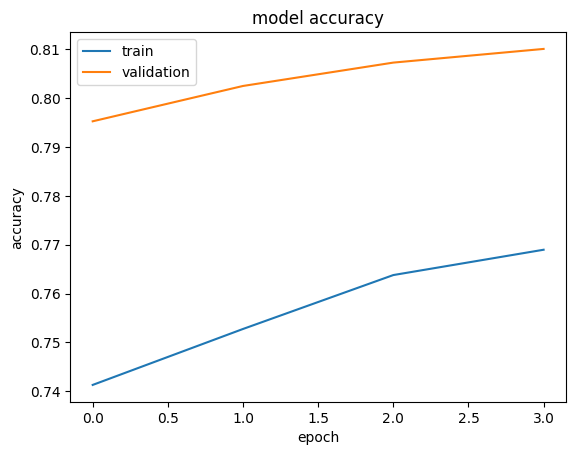

In [12]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

